# Credit Risk Analysis - The Quantum Way

### _Sergio Gago Huerta_

### Can Quantum Computers help financial institutions make more moneys?

![](imgs/cat_money.jpg)

### Agenda
* Why do we need credit risk analysis - Basel II and Basel III
* The Montecarlo methods, where they fall. Their complexity
* Enter QAE - A quick and non rigourous analysis on Brassard, Grover and others work
* QAE for Credit risk - mapping probability distributions


Work based on the following papers:

- <a href="https://arxiv.org/abs/1412.1183">Regulatory Capital Modelling for Credit Risk. Marek Rutkowski, Silvio Tarca</a>
- <a href="https://www.nature.com/articles/s41534-019-0130-6">Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger.</a> [Woerner2019]
- <a href="https://arxiv.org/abs/1907.03044">Credit Risk Analysis using Quantum Computers. Egger et al. (2019)</a> [Egger2019]
- <a href="http://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Gilles Brassard et al.</a>
- And many others, check the references and bibliography and have a blast

- Scripts, tests, experiments, papers and memorabilia in the repo: https://github.com/sergiogh/upc_credit_risk

- Basel II and all its financial jaron, here: https://www.bis.org/publ/bcbsca05.pdf

### Problem Definition

Basel II with the IRB process (Internal Ratings Based aproach) need a way to evaluate risk properly. For that they have adopted the One-Factor Gaussian Copula method, as estated in the regulatory capital methods paper.

Basically we want to analyze the credit risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the _loss given default_ of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk of $L$ (also called Expected Shortfall). Where VaR and CVaR are defined as

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \}$$

with confidence level $\alpha \in [0, 1]$, and

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L) ].$$

For more details on the considered model, see, e.g.,<br>
<a href="https://arxiv.org/abs/1412.1183">Regulatory Capital Modeling for Credit Risk. Marek Rutkowski, Silvio Tarca</a>



.


![](./imgs/wat.jpg)

### So I read the paper 3 more times

![](imgs/watwatwat.jpg)

## Credit Risk - Lets start from the beginning
* Banks and financial institutions lend money to people so we mortals can buy houses.
* Banks tend to lend more money than the one they have (greedy bastards). Kind of overbooking plane seats. They rely on you not going to the ATM to get all your money at once
* Then 2008 happened and a financial crisis destroyed employment, money, killed cats and made babies cry. So Europe (and others started to think very deep).
* We should ask the banks to actually HAVE some of the money the lend. Brilliant! Everyone congratulated themselves and went out for beers...


... but how much money?

The Basel accords establish a maximum of risk banks can afford depending on the types of loans they sell. Banks have an incentive to sell more loans because they get exquisite interest rates out of them. But... what happens with one loan defaults? Yes, you lose your house but the bank gets "bad debt" and that goes in their books. Their assets depreciate and it starts a whirlwind of financial issues that end in a financial crisis.

## But how can you know when and who will default in a loan?

EXACTLY. This is a purely probabilistic situation. You may be out of a job and stop paying your debt, our country can go into war or there could be a massive currency inflation. All those events can be mapped in probabilistic events and then you can simulate all the possibilities using Montecarlo simulations. Then you decide which level of risk you are confortable with and voilà! You have the probability at which you will lose certain amount of your money. (Black swans and long tail events aside)

### But hey, how much money are we talking about? Enter VaR

![](imgs/var_football.jpg)

### Not that VaR

This VaR

![](imgs/var.png)

The Value at Risk si a measurement of how much "money" you can lose for a given level of risk and a function that models the uncertainty of such assets (i.e. subprime mortages in an empoverished country). It is a measure for what the maximum expected loss is, given some 1 — α% probability and some time horizon T.

In short
> "with 95% probability, the investor will not lose more than VaR(α = 0.95)".

But this Value At Risk does not fully evaluate what happens in the tail (i.e. a big financial crisis, black swans or other stuff that happens because we are greedy humans)

Enter *Expected Shortfall* (or Conditional Value at Risk among friends)

![](imgs/cvar.png)

Since Basel II
_“Unlike VaR, ES measures the riskiness of an instrument by considering both the size and likelihood of losses above a certain threshold … In this way, ES accounts for tail risk in a more comprehensive manner”_

So, the European Union imposes some Capital Requirements to avoid having to rescue them again and they don't get incentives to make risky bets with everybody's money. For that they calculate the expected loss, VaR and CVaR (expected shortfall) of all their assets (Ha! take that spanish cajas!)

![](imgs/expected_loss.png)

They get something like this

![](imgs/expected_loss_var.png)

et voilà! Now they know how many subprime loans they can give without going bankrupt and make lots of money in incentives for selling morgages!

## The Classical Way: Markov Chain Monte Carlo Methods
_And the Metropolis Algorithm_

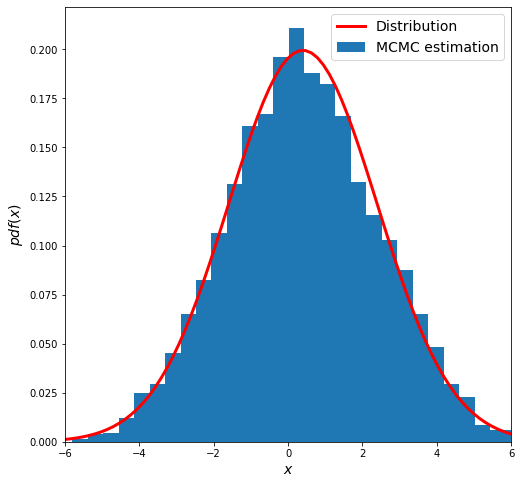

In [1]:
### The classical way
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Metropolis-Hastings MCMC
def metropolis(func, steps=10000):

    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    
    return samples

# distribución normal
func = stats.norm(0.4, 2)
samples = metropolis(func=func, steps=10000)
x = np.linspace(-6, 10, 100)
y = func.pdf(x)
plt.figure(figsize=(8,8))
plt.xlim(-6, 6)
plt.plot(x, y, 'r-', lw=3, label='Distribution')
plt.hist(samples, bins=30, density=True, label='MCMC estimation')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Enter QAE
### The Quantm Way

There is a way we can estimate the probability of an event in a given probability distribution with a quantum computer.

![QAE Circuit](imgs/QAE.png)

# Looks familiar?

### Shor Circuit

![Shor](imgs/shor_circuit.png)
### QPE Circuit
![QPE](imgs/qpe_circuit.png)


_Need a refresher on QPE? Look at this_
[QPE Demo!](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C1%2C1%2C%7B%22id%22%3A%22Z%5Eft%22%2C%22arg%22%3A%22t%22%7D%5D%2C%5B1%2C%22%E2%80%A2%22%2C1%2C1%2C%7B%22id%22%3A%22Z%5Eft%22%2C%22arg%22%3A%22t*2%22%7D%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C%7B%22id%22%3A%22Z%5Eft%22%2C%22arg%22%3A%22t*4%22%7D%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C%7B%22id%22%3A%22Z%5Eft%22%2C%22arg%22%3A%22t*8%22%7D%5D%2C%5B%22QFT%E2%80%A04%22%5D%2C%5B%22Chance4%22%5D%5D%7D)

## QAE

Quantum Amplitude Estimation (QAE) is a fundamental quantum algorithm with the potential to achieve a quadratic speedup for many applications that are classically solved through Monte Carlo (MC) simulation (From credit risk here, to option pricing or any other stochastic process). While the estimation error of classical MC simulation scales as $O(1/\sqrt{M})$, where M denotes the number of (classical) samples, QAE achieves a scaling of $O(1/M)$ for M (quantum) samples, which implies such quadratic speedup. 

In classical montecarlos, banks tend to simplify their parameters and sample billions of iterations, in a way that it can take days to perform production-like simulations. It has been theoritized that this methods could predict financial crisis (Roman Orus, 201X... some years ago, whatever)

The canonical version of QAE is a combination of Quantum Phase Estimation (QPE) and Grover’s Algorithm. Since other QPE-based algorithms are believed to achieve exponential speedup, (Shor’s Algorithm for factoring is one example). However QPE introduces lenghty circtuits and require many qubits making it impracticable for today's NISQ computers. Many approaches exist today to remove the QFT from the algorithm and still achieve a similar speedup in the process. In this project we use te Iterative QAE (see later)

To apply QAE we map the problem in a quantum operator $\mathcal{A}$
$$ \mathcal{A} |0\rangle_{n+1} = \sqrt{1 - a} |\psi_0\rangle_n |0\rangle + \sqrt{a} |\psi_1\rangle_n |1\rangle $$

where $a ∈ [0, 1]$ is the unknown probability of measuring |1>, and $|\psi_0\rangle_n$ and $|\psi_1\rangle_n$ are two normalized states, not necessarily orthogonal. QAE allows to estimate a with high probability such that the estimation error scales as O(1/M), where M corresponds to the number of applications of $ \mathcal{A} $. 

To this extent, an operator $\mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f,$ is defined where 
$ \mathcal{S} \psi_0 = \mathcal{I-2}|\psi_0\rangle_n\langle\psi_0|_n |0\rangle\langle0|$
and $ \mathcal{S}_0 = \mathcal{I-2}|0\rangle_{n+1}
\langle0|_{n+1} $

The canonical QAE follows the form of QPE: it uses m ancilla qubits – initialized in equal superposition – to represent the final result, it defines the number of quantum samples as $M = 2m$ and applies geometrically increasing powers of Q controlled by the ancillas. Eventually, it performs a QFT on the ancilla qubits before they are measured. The measured integer $ y ∈ {0,...,M − 1} $ is mapped to an angle $\theta ̃_a = yπ/M$. Thereafter, the resulting estimate of a is defined as $a ̃ = sin^2 (\theta ̃a )$


### In short: You need a hell lot of qubits, and a very deep circuit that does a QFT in the end


### The problem is defined by the following parameters:
- Number of qubits used to represent the gaussian probabiltiy $Z$, denoted by $n_z$
- Limits for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- Base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- Sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1]$
- Loss given default for asset $k$, denoted by $\lambda_k$ (how much you lose if the loan defaults)
- Confidence level for VaR / CVaR $\alpha \in [0, 1]$.

In [2]:

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.circuit.library import IntegerComparator, LinearAmplitudeFunction, WeightedAdder
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation, AmplitudeEstimation
from qiskit.visualization import plot_histogram

from qiskit.finance.applications import GaussianConditionalIndependenceModel as GCI

from kaleidoscope import probability_distribution


In [3]:
######################
# Problem parameters #
######################

# Each asset mapped as [default probability, sensitivity o the PDF, loss given default (expressed in '0.000)]

problem_size = 4

total_mortgages = [[0.15, 0.1, 100000],
                    [0.25, 0.05, 200000],
                    [0.2, 0.07, 300000],
                    [0.02, 0.01, 400000],
                    [0.05, 0.05, 300000],
                    [0.2, 0.03, 390000],
                    [0.01, 0.01, 100000],
                    [0.03, 0.09, 120000],
                    [0.2, 0.07, 300000],
                    [0.02, 0.01, 400000],
                    [0.05, 0.05, 300000],
                    [0.25, 0.05, 310000],
                    [0.01, 0.01, 600000],
                    [0.05, 0.01, 800000],
                    [0.04, 0.01, 300000],
                    [0.2, 0.4, 560000],
                    [0.7, 0.10, 100000],
                    [0.04, 0.01, 100000],
                    [0.2, 0.07, 300000],
                    [0.02, 0.01, 400000],
                    [0.05, 0.05, 300000],
                    [0.02, 0.03, 390000],
                    [0.1, 0.01, 200000],
                    [0.04, 0.01, 600000],
                    [0.03, 0.01, 700000]]

# Get only a subset when making the problem smaller
mortgages = total_mortgages[:problem_size]

# Confidence level for VaR and CVaR. On BaselII around 99,9%
alpha = 0.1

#IBMQ.load_account()
#provider = IBMQ.get_provider()
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

In [4]:
mortgages

[[0.15, 0.1, 100000],
 [0.25, 0.05, 200000],
 [0.2, 0.07, 300000],
 [0.02, 0.01, 400000]]

In [5]:
# Mapping parameters
# Loss Given Default multiplier (we can't map very big numbers, so we eliminate zeroes, from X00,000 -> X0)
lgd_factor = 100000

# Z represents our distribution, discretized with n qubits. The more qubits, the merrier. (I.e. the more values we will be able to approximate)
n_z = 3
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)

K = len(mortgages)

probability_default = []
sensitivity_z = []
loss_given_default = []
for m in mortgages:
    probability_default.append(m[0])
    sensitivity_z.append(m[1])
    loss_given_default.append(int(m[2] / lgd_factor))   # LGD is simplified, reduced proportionately and taken only the integer part


In [6]:
# TEST removing all sensitivity, making ALL assets losses independent.
#sensitivity_z = np.zeros(K)
#print(sensitivity_z)

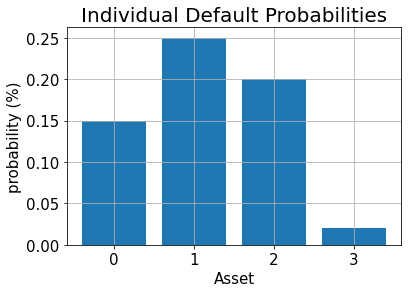

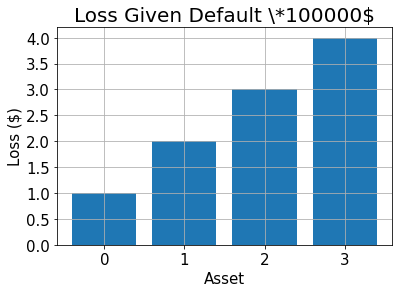

In [7]:
# plot results for default probabilities
plt.bar(range(K), probability_default)
plt.xlabel('Asset', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Individual Default Probabilities', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# plot Loss Given Defaults
plt.bar(range(K), loss_given_default)
plt.xlabel('Asset', size=15)
plt.ylabel('Loss ($)', size=15)
plt.title('Loss Given Default \*'+str(lgd_factor) +'$', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# Part 1 - Build the model and test classically
_Start slow and easy_

### Uncertainty Model

We now construct a circuit that loads the uncertainty model. This can be achieved by creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. The resulting quantum state can be written as

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K \left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),$$

Where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$ [Egger2019].

Yes

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

is the same as 

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K \left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),$$

![](imgs/cat.jpg)

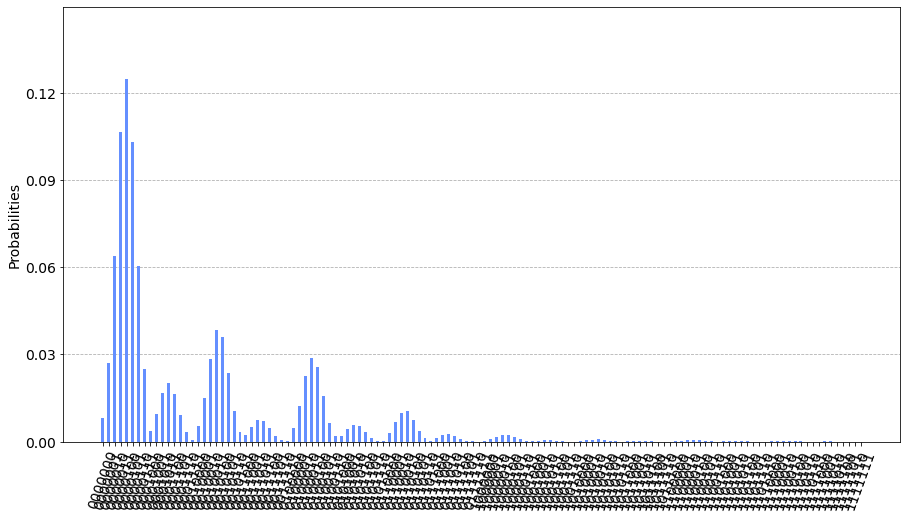

In [8]:
uncertainty_model = GCI(n_z, z_max, probability_default, sensitivity_z) 
job = execute(uncertainty_model, backend=Aer.get_backend('statevector_simulator'))
plot_histogram(job.result().get_counts(), figsize=(15, 8), bar_labels=False)

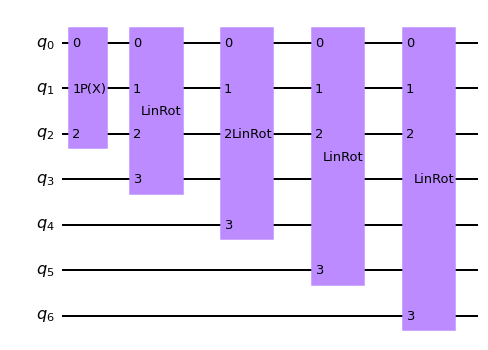

In [9]:
uncertainty_model.draw('mpl')

### Quantum Probability Distributions

Here you can see some more details on how to create Probability distributions with Qiskit and Quantum Circuits

https://github.com/sergiogh/upc_credit_risk/blob/main/Probability%20Distributions%20and%20AE.ipynb

In [10]:
## Sample all results and evaluate probabilities. Effectively this is like 
# running a MC method but we are too lazy to build the PF clasically :) 

uncertainty_model = GCI(n_z, z_max, probability_default, sensitivity_z) 
job = execute(uncertainty_model, backend=Aer.get_backend('statevector_simulator'))

p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = uncertainty_model.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    # extract value of Z and corresponding probability    
    # Note Z i mapped in the least significant n_z qubits. We add probabilities for each element in the distribution
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    # Most significant qubits represent 1 for default of that asset.
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += loss_given_default[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
# L = λ1*X1(Z) + λ2*X2(Z) + ... + λn*Xn(Z)
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var+1):], losses[(i_var+1):])/sum(pdf[(i_var+1):])

# Calculate P[L <= VaR[L]]
alpha_point = np.where(values == exact_var)[0].min()
p_l_less_than_var = cdf[exact_var]

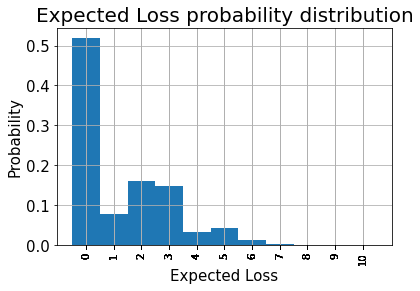

In [11]:
plt.bar(losses, pdf, width=1)
plt.xlabel('Expected Loss', size=15)
plt.ylabel('Probability', size=15)
plt.title('Expected Loss probability distribution', size=20)
plt.xticks(values, size=10, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.show()

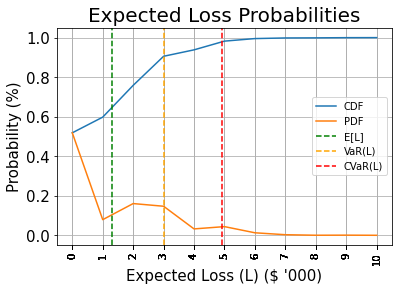

In [12]:
plt.plot(np.unique(values), cdf, label="CDF")
plt.plot(np.unique(values), pdf, label="PDF")
plt.xlabel('Expected Loss (L) ($ \'000)', size=15)
plt.ylabel('Probability (%)', size=15)
plt.title('Expected Loss Probabilities', size=20)
plt.xticks(values, size=10, rotation=90)
plt.yticks(size=15)
plt.axvline(expected_loss, color='green', linestyle='--', label='E[L]')
plt.axvline(exact_var, color='orange', linestyle='--', label='VaR(L)')
plt.axvline(exact_cvar, color='red', linestyle='--', label='CVaR(L)')
plt.legend()
plt.grid()
plt.show()


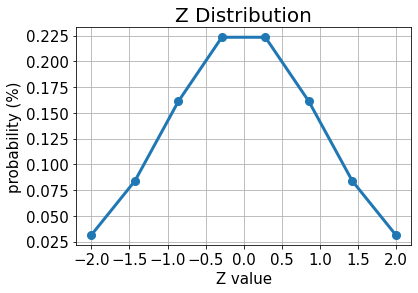

In [13]:
# plot results for Z
plt.plot(z_values, p_z, 'o-', linewidth=3, markersize=8)
plt.grid()
plt.xlabel('Z value', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Z Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [14]:

print('LGD: ', loss_given_default, ' Total Assets value: $ {0:12,.0f}'.format(sum(loss_given_default)*lgd_factor))
print('Assets: ', K)
print('Assets default Probabilities: ', probability_default)
print('Expected Loss E[L]:                $ {0:12,.0f}'.format(expected_loss*lgd_factor))
print('Value at Risk VaR[L](%.2f):        $ {0:12,.0f}'.format((exact_var*lgd_factor)) % (alpha))
print('P[L <= VaR[L]](%.2f):              %.4f' % (alpha, p_l_less_than_var))
print('Conditional Value at Risk CVaR[L]: $ {0:12,.0f}'.format(exact_cvar*lgd_factor))


LGD:  [1, 2, 3, 4]  Total Assets value: $    1,000,000
Assets:  4
Assets default Probabilities:  [0.15, 0.25, 0.2, 0.02]
Expected Loss E[L]:                $      130,715
Value at Risk VaR[L](0.10):        $      300,000
P[L <= VaR[L]](0.10):              0.9056
Conditional Value at Risk CVaR[L]: $      492,839


# Part 2 - Expected Loss with Quantum and QAE
_Bring it on_

## Iterative Quantum Amplitude Estimation


QAE is very expensive, requires many ancillas to obtain a proper estimation of the value and several powers of Q. However we can realize that (from Woerner's IQAE paper) the probability of measuring |1⟩ in the last qubit is given by
$P[|1⟩] = sin^2((2k + 1)θ_a)$

We can then estimate for the last Qubit $Q^k\mathcal{A}|0\rangle_n |0\rangle$ with some confidence interval... and success!

We do that by iteratively take samples ok K using a bisection search (i.e. running the whole algorithm several times) until we reach the confidence level). See below how the magic happens.

With that we are able to run this problem in noisy computers and increase the problem size (from 4-5 assets to almost 20, peanuts, but bigger peanuts!)




![](imgs/iqae_algorithm.png)

## More on QAE

You will not believe what happens if you create your own QAE circuit by yourself and run it in a noisy device. The answer will surprise you:
https://github.com/sergiogh/upc_credit_risk/blob/main/Amplitude%20Estimation%20v2.ipynb

## Expected Loss

To estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S}. $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1. $$

Once we have the total loss distribution in a quantum register, we can use the techniques described in [Woerner2019] to map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto | L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right),$$

which allows to run amplitude estimation to evaluate the expected loss.


Weighted Adder operator:

$$|q_0 \ldots q_{n-1}\rangle |0\rangle_s \mapsto |q_0 \ldots q_{n-1}\rangle |\sum_{j=0}^{n-1} \lambda_j q_j\rangle_s$$



                   ┌────────┐
          state_0: ┤0       ├ | state_0 * weights[0]
                   │        │ |
          state_1: ┤1       ├ | + state_1 * weights[1]
                   │        │ |
          state_2: ┤2       ├ | + state_2 * weights[2]
                   │        │ |
          state_3: ┤3       ├ | + state_3 * weights[3]
                   │        │
            sum_0: ┤4       ├ |
                   │  Adder │ |
            sum_1: ┤5       ├ | = sum_0 * 2^0 + sum_1 * 2^1 + sum_2 * 2^2
                   │        │ |
            sum_2: ┤6       ├ |
                   │        │
          carry_0: ┤7       ├
                   │        │
          carry_1: ┤8       ├
                   │        │
        control_0: ┤9       ├
                   └────────┘

In [15]:
# add Z qubits with weight/loss 0

# ```WeightedAdder(num_state_qubits=None, weights=None, name='adder') ````

# We need as many state qubits as our definition of Z + number of assets: |x1,...xk>|0>ns
# We only add weights to the lgd elements of the sum and add 0 to the Z (not really adding them)

weighted_adder = WeightedAdder(n_z + K, [0]*n_z + loss_given_default)



In [16]:
#weighted_adder.draw()
print(weighted_adder.num_qubits)

15


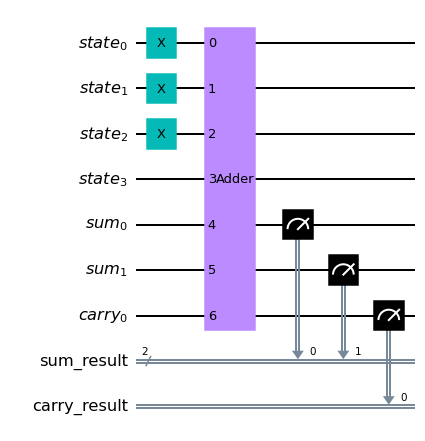

In [17]:
# Test Aggregator - Just to make sure we understand what it odes and why
# Lets do a quick test to validate the WeightedAdder Qiskit function

test_adder = WeightedAdder(4, [0,0,1,1])    # Adds only the last two state qubits


state_registry = QuantumRegister(test_adder.num_state_qubits, 'state')
sum_registry = QuantumRegister(test_adder.num_sum_qubits, 'sum')
carry_registry = QuantumRegister(test_adder.num_carry_qubits, 'carry')
sum_result = ClassicalRegister(test_adder.num_sum_qubits, 'sum_result')
carry_result = ClassicalRegister(test_adder.num_carry_qubits, 'carry_result')

if test_adder.num_control_qubits > 0:
    control_registry = QuantumRegister(test_adder.num_control_qubits, 'control')
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, control_registry, sum_result, carry_result)
else:
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, sum_result, carry_result)

test_adder_circuit.x(state_registry[0])
test_adder_circuit.x(state_registry[1])
test_adder_circuit.x(state_registry[2])
#test_adder_circuit.x(state_registry[3])

test_adder_circuit.append(test_adder, range(test_adder.num_qubits))
test_adder_circuit.measure(sum_registry, sum_result)
test_adder_circuit.measure(carry_registry, carry_result)
test_adder_circuit.draw('mpl')



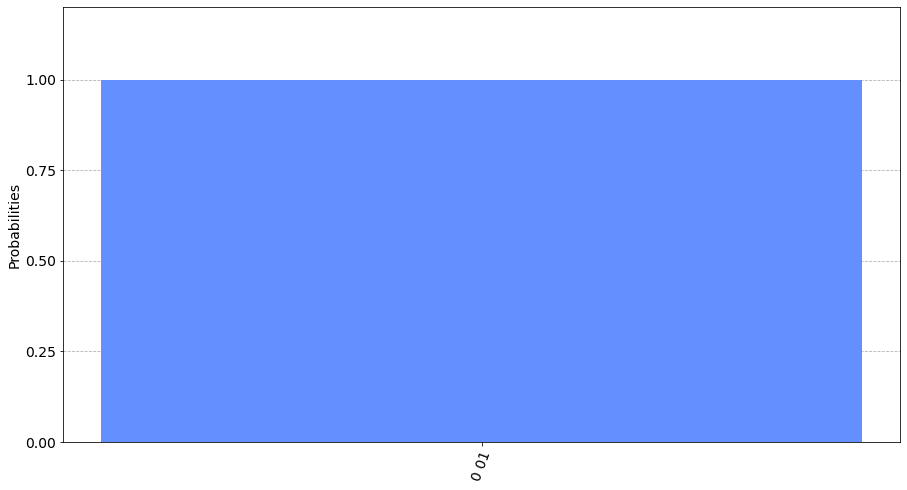

In [18]:
job = execute(test_adder_circuit, backend=Aer.get_backend('statevector_simulator'))
plot_histogram(job.result().get_counts(), figsize=(15, 8), bar_labels=False)

### Linear Amplitude Function 

~~~
CLASSLinearAmplitudeFunction(num_state_qubits, slope, offset, domain, image, rescaling_factor=1, breakpoints=None, name='F')
~~~


A circuit implementing a (piecewise) linear function on qubit amplitudes.

An amplitude function 𝐹 of a function 𝑓 is a mapping
$$F|x\rangle|0\rangle = \sqrt{1 - \hat{f}(x)} |x\rangle|0\rangle + \sqrt{\hat{f}(x)} |x\rangle|1\rangle.$$

for a function $ \hat{f}: \{0, ..., 2^n - 1\} \rightarrow [0, 1] $, where |𝑥⟩ is a $n$ qubit state.

This circuit implements F for piecewise linear functions $\hat{f}$. In this case, the mapping F can be approximately implemented using a Taylor expansion and linearly controlled Pauli-Y rotations. This approximation uses a rescaling_factor to determine the accuracy of the Taylor expansion.

In general, the function of interest f is defined from some interval $[a,b]$, 'domain' to $ [c,d]$, the 'image', instead of $ \{1, ..., N\} $ to $[0, 1]$. Usng an affine transformation we can rescale $f$ to $ \hat{f} $ :

$$\hat{f(x)} = \frac{f(\phi(x)) - c}{d - c}$$

with

$$\phi(x) = a + \frac{b - a}{2^n - 1} x $$

If $ f $ is a piecewise linear function on 'm' intervals $ [p_{i-1}, p_i], i \in \{1, ..., m\} $ with slopes $ \alpha_i $ and offsets $ \beta_i $ it can be written as

$$f(x) = \sum_{i=1}^m 1_{[p_{i-1}, p_i}(x) (\alpha_i x + \beta_i)$$

where $ 1_[a, b] $ is an indication function that is 1 if the argument is in the interval $ [a, b] $ and otherwise 0. The breakpoints $ p_i $ can be specified by the 'breakpoints' argument.

In [19]:

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(loss_given_default)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slope=slopes, 
    offset=offsets, 
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**weighted_adder.num_sum_qubits-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
    name="F"
)

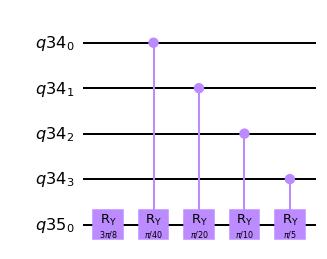

In [20]:
objective.decompose().draw('mpl')

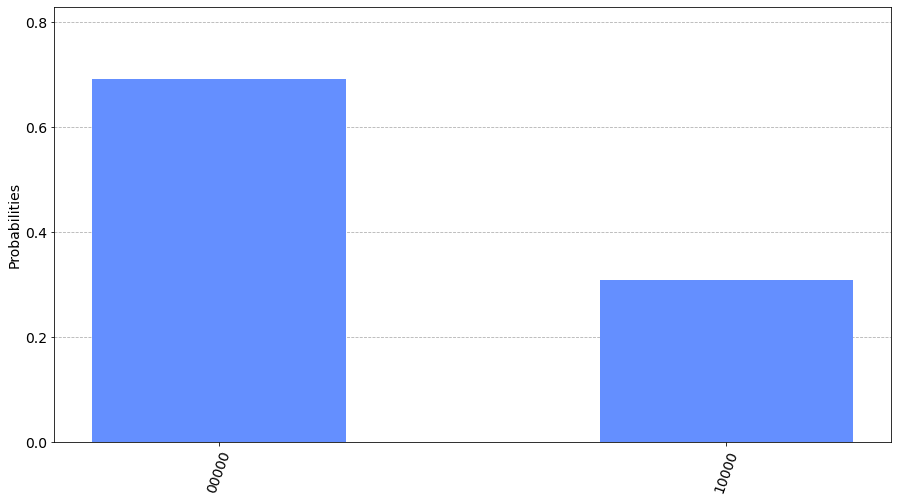

In [21]:
job = execute(objective, backend=Aer.get_backend('statevector_simulator'))
plot_histogram(job.result().get_counts(), figsize=(15, 8), bar_labels=False)

## Put everything together for the state preparation

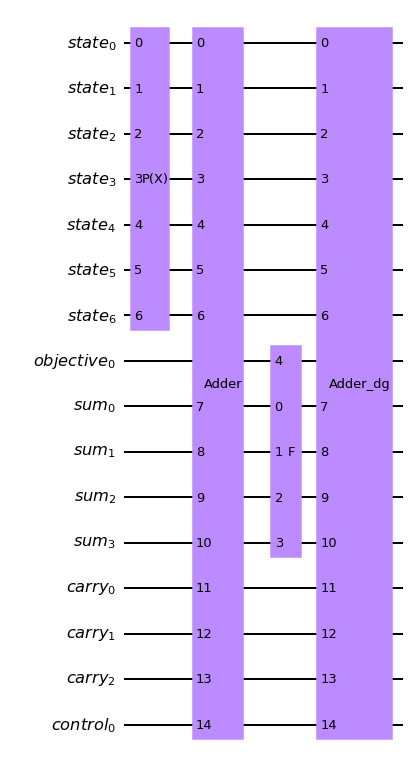

In [22]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')
qr_control = QuantumRegister(1, 'control')


# define the circuit
if weighted_adder.num_control_qubits > 0:
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_control, name='A')
    state_preparation.append(uncertainty_model.to_gate(), qr_state)
    state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
    state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])
else: 
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')
    state_preparation.append(uncertainty_model.to_gate(), qr_state)
    state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
    state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])


# draw the circuit
state_preparation.draw('mpl')

In [23]:
from qiskit import transpile
print("Required Qubits: ", state_preparation.decompose().num_qubits)

backend = Aer.get_backend('qasm_simulator')
optimized_0 = transpile(state_preparation, backend=backend, seed_transpiler=11, optimization_level=0)
print("No Optimization")
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

optimized_3 = transpile(state_preparation, backend=backend, seed_transpiler=11, optimization_level=3)
print("High Optimization")
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

Required Qubits:  16
No Optimization
gates =  OrderedDict([('x', 64), ('cx', 60), ('u3', 32), ('ccx', 32), ('mcx', 32), ('ry', 12)])
depth =  119
High Optimization
gates =  OrderedDict([('cx', 682), ('p', 490), ('t', 96), ('tdg', 94), ('h', 90), ('x', 53), ('u', 41), ('ry', 12), ('u2', 4)])
depth =  1133


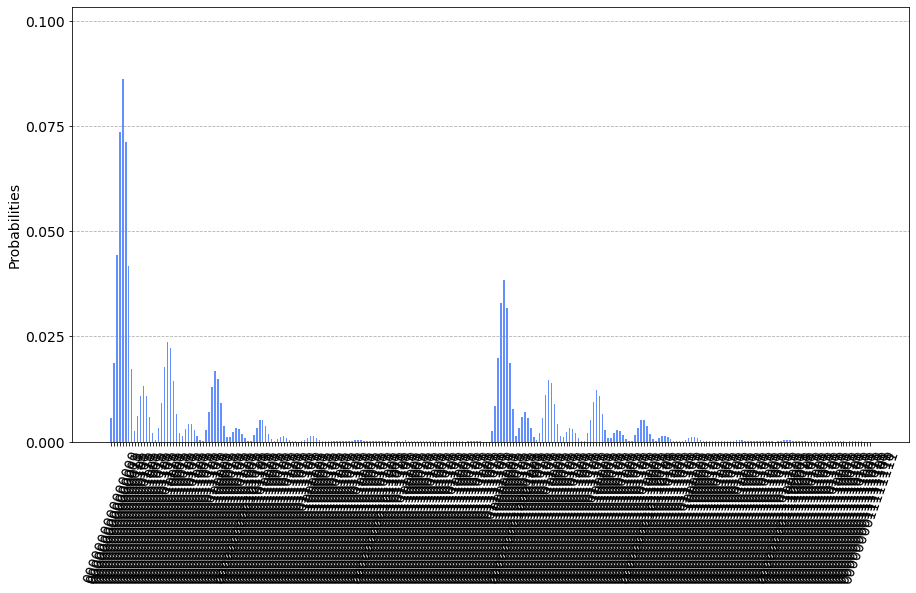

In [24]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))
plot_histogram(job.result().get_counts(), figsize=(15, 8), bar_labels=False)

## Test clasically


We evaluate going through the samples the probability of finding |1>
In principle the QAE or IQAE should approximate such value. _(This might take a while to run... you are going through all samples my friend)_

In [25]:
# evaluate resulting statevector
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

In [26]:

print('Exact Expected Loss:   $ {0:12,.0f}'.format(expected_loss*lgd_factor))
print('Exact Operator Value (probability):  %.4f' % value)
print('Mapped Operator value: $ {0:12,.0f}'.format(objective.post_processing(value)*lgd_factor))

Exact Expected Loss:   $      130,715
Exact Operator Value (probability):  0.3579
Mapped Operator value: $      138,257


In [27]:
state_preparation.num_qubits

16

In [28]:
# Now, pure quantum estimation
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

# set target precision and confidence level
epsilon_iae = 0.01
alpha_iae = 0.05

# construct amplitude estimation 
iae = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                  epsilon=epsilon_iae, alpha=alpha_iae,
                                  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result = iae.run(quantum_instance=backend, shots=100)


In [29]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:   $ {0:9,.0f}'.format(expected_loss*lgd_factor))
print('Estimated value: $ {0:9,.0f}'.format(result['estimation']*lgd_factor))
print('Confidence interval: \t[%.0f, %.0f]' % (tuple(conf_int*lgd_factor)))

Exact value:   $   130,715
Estimated value: $   139,462
Confidence interval: 	[133500, 145424]


In [30]:
# Try with "standard" QAE and see what happens

# AmplitudeEstimation(num_eval_qubits, state_preparation=None, grover_operator=None, objective_qubits=None, post_processing=None, phase_estimation_circuit=None, iqft=None, quantum_instance=None, a_factory=None, q_factory=None, i_objective=None)

#evaluation_qubits = 3
#ae = AmplitudeEstimation(evaluation_qubits, state_preparation=state_preparation)
#ae_result = ae.run(quantum_instance=backend, shots=1000)

In [31]:
#conf_int = np.array(ae_result['confidence_interval'])
#print('Exact value:   $ {0:9,.0f}'.format(expected_loss*lgd_factor))
#print('Estimated value: $ {0:9,.0f}'.format(ae_result['estimation']*lgd_factor))
#print('Confidence interval: \t[%.0f, %.0f]' % (tuple(conf_int*lgd_factor)))

## Great, now what?

The expected loss is fine, but this is very easy to calculate even with an excel spreadsheet. However estimating the *Cumulative Distribution Function* is another story. Classically we would need a very expensive Montecarlo that grows exponentially with the size of the problem.

![CDF Calculation using the Unitary, the weighted adder and the comparator](imgs/CDF_calculation_quantum_risk.png)

To estimate the CDF, i.e., the probability $ \mathbb{P} [L  \leq  x] $ , we compute the total loss the same way as before and then apply a comparator.

$$ \begin{split} \mathcal{C}: |L\rangle_n|0> \mapsto \begin{cases} |L\rangle_n|1> & \text{if}\quad L \leq x \\ |L\rangle_n|0> & \text{if}\quad L > x. \end{cases}\end{split} $$

The CDF(𝑥) equals the probability of measuring |1⟩ in the objective qubit. So we appliy IQAE et voilà!



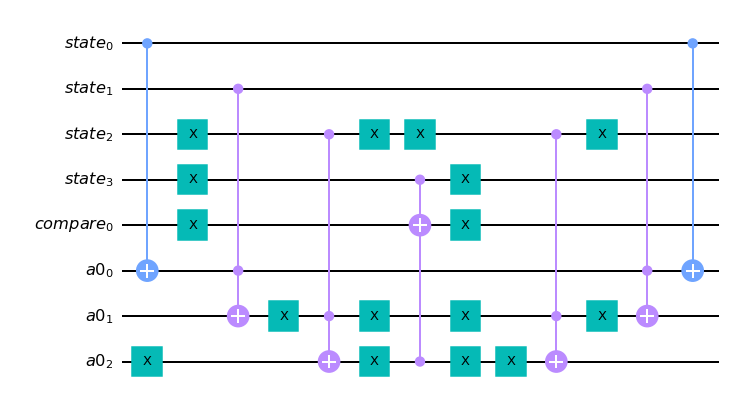

In [32]:
# We use an IntegerComparator
# IntegerComparator(num_state_qubits=None, value=None, geq=True, name='cmp')
# Operator compares basis states |𝑖⟩𝑛 against a classically given integer 𝐿 of fixed value and flips a target qubit if 𝑖≥𝐿 (or < depending on the parameter geq):

# So basically we compare the sum from before with value that has L on the objective_qubit.

comparator_value = 2

comparator = IntegerComparator(weighted_adder.num_sum_qubits, comparator_value + 1, geq=False)
comparator.draw('mpl')

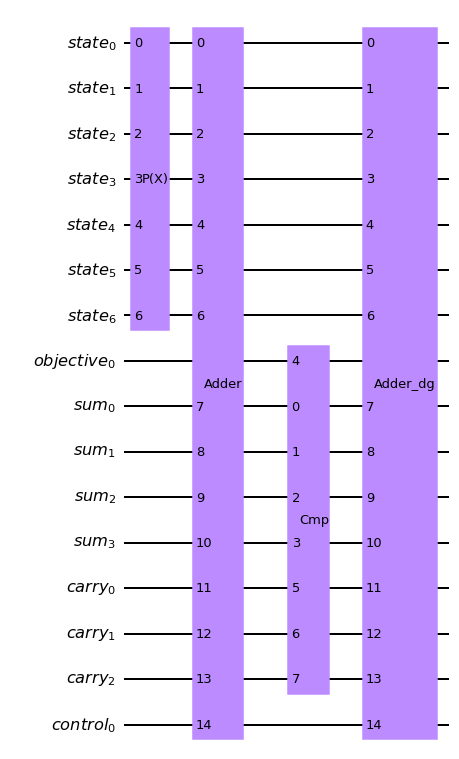

In [33]:
def build_cdf_state_preparation(comparator_value, uncertainty_model, weighted_adder):
    cdf_qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
    cdf_qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
    cdf_qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
    cdf_qr_obj = QuantumRegister(1, 'objective')
    
    comparator = IntegerComparator(weighted_adder.num_sum_qubits, comparator_value + 1, geq=False)

    if weighted_adder.num_control_qubits > 0:
        cdf_qr_control = QuantumRegister(weighted_adder.num_control_qubits, 'control')
        cdf_state_preparation = QuantumCircuit(cdf_qr_state, cdf_qr_obj, cdf_qr_sum, cdf_qr_carry, cdf_qr_control, name='A')
        cdf_state_preparation.append(uncertainty_model, cdf_qr_state)
        cdf_state_preparation.append(weighted_adder, cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:] + cdf_qr_control[:])
        cdf_state_preparation.append(comparator, cdf_qr_sum[:] + cdf_qr_obj[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:] + cdf_qr_control[:])
    else:
        cdf_state_preparation = QuantumCircuit(cdf_qr_state, cdf_qr_obj, cdf_qr_sum, cdf_qr_carry, name='A')
        cdf_state_preparation.append(uncertainty_model, cdf_qr_state)
        cdf_state_preparation.append(weighted_adder, cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(comparator, cdf_qr_sum[:] + cdf_qr_obj[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
    
    return cdf_state_preparation

weighted_adder = WeightedAdder(n_z + K, [0]*n_z + loss_given_default)
comparator_value = 2
cdf_state_preparation = build_cdf_state_preparation(comparator_value, uncertainty_model, weighted_adder)
cdf_state_preparation.draw('mpl')


In [34]:
# Test for a single value on the CDF
# set target precision and confidence level
epsilon_iae = 0.01
alpha_iae = 0.05

# construct amplitude estimation
iae_cdf = IterativeAmplitudeEstimation(state_preparation=cdf_state_preparation,
                                      epsilon=epsilon_iae, alpha=alpha_iae,
                                      objective_qubits=[len(qr_state)])
iae_result_cdf = iae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
cdf_conf_int = np.array(iae_result_cdf['confidence_interval'])
print("Test for a single test comparison value: ", comparator_value)
print('Exact value:    \t%.4f' % cdf[comparator_value])
print('Estimated value:\t%.4f' % iae_result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(cdf_conf_int))

Test for a single test comparison value:  2
Exact value:    	0.7585
Estimated value:	0.7612
Confidence interval: 	[0.7564, 0.7661]


Once we have the CDF properly estimated, we can go ahead and get the VaR and CVaR using the Bisection search

In [35]:
target_value = 1 - alpha
low_level = min(losses) - 1
high_level = max(losses)
low_value = 0
high_value = 1

# check whether low and high values are given and evaluated them otherwise
print('--------------------------------------------------------------------')
print('start bisection search for target value %.3f' % target_value)
print('--------------------------------------------------------------------')
num_eval = 0

# check if low_value already satisfies the condition
if low_value > target_value:
    level = low_level
    value = low_value
    print("Low value found")
elif low_value == target_value:
    level = low_level
    value = low_value
    print("Convergence found")

# check if high_value is above target
if high_value < target_value:
    level = high_level
    value = high_value
    print("Low value found")
elif high_value == target_value:
    level = high_level
    value = high_value
    print("Convergende found")

# perform bisection search until
print('low_level    low_value    level    value    high_level    high_value')
print('--------------------------------------------------------------------')
while high_level - low_level > 1:

    level = int(np.round((high_level + low_level) / 2.0))
    num_eval += 1

    cdf_state_pareparation = build_cdf_state_preparation(level, uncertainty_model, weighted_adder)
    iae_var = IterativeAmplitudeEstimation(state_preparation=cdf_state_pareparation, epsilon=0.01, alpha=0.05, objective_qubits = [uncertainty_model.num_qubits])
    value = iae_var.run(quantum_instance=backend, shots=100)['estimation']

    print('%2d           %.3f        %2d       %.3f    %2d            %.3f' % (low_level, low_value, level, value, high_level, high_value))

    if value >= target_value:
        high_level = level
        high_value = value
    else:
        low_level = level
        low_value = value


# return high value after bisection search
print('--------------------------------------------------------------------')
print('finished bisection search')
print('--------------------------------------------------------------------')
print('VaR: ', level)
var = level
estimated_probability = value


--------------------------------------------------------------------
start bisection search for target value 0.900
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         4       0.938    10            1.000
-1           0.000         2       0.755     4            0.938
 2           0.755         3       0.905     4            0.938
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------
VaR:  3


## The Circuit

We are building our uncertainty model, the adders and the comparator with different levels in order to run the IAE. Each iteration of the bisection search runs the model once with a different level to compare, converging eventually to our desired VaR

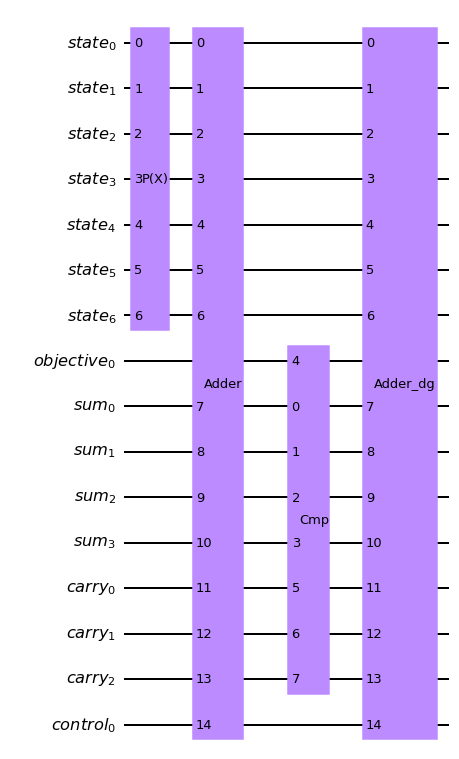

In [36]:
cdf_state_preparation.draw('mpl')

In [37]:
print('Estimated Value at Risk: $ {0:9,.0f}'.format(var * lgd_factor))
print('Exact Value at Risk: $ {0:9,.0f}'.format(exact_var * lgd_factor))

print('Estimated Probability:    %.3f' % estimated_probability)
print('Exact Probability:        %.3f' % cdf[exact_var])

Estimated Value at Risk: $   300,000
Exact Value at Risk: $   300,000
Estimated Probability:    0.905
Exact Probability:        0.906


# Lastly, get CVaR

Expected value of the loss conditional to it being larger than or equal to the VaR. To do so, we evaluate a piecewise linear objective function 𝑓(𝐿), dependent on the total loss 𝐿

$$ \begin{split} f(L) = \begin{cases} 0 & \text{if}\quad L \leq VaR \\L & \text{if}\quad L > VaR. \end{cases}\end{split} $$

To normalize, we have to divide the resulting expected value by the VaR-probabilit


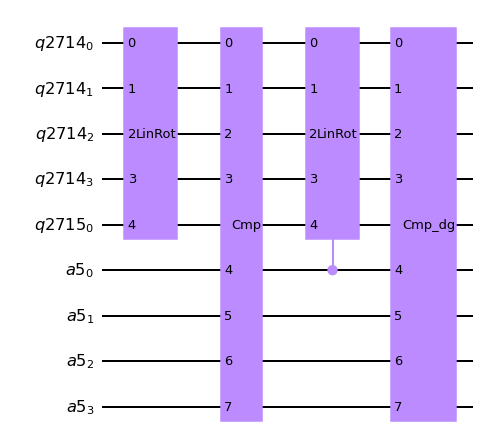

In [38]:
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = sum(loss_given_default) - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**weighted_adder.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

cvar_objective.draw('mpl')

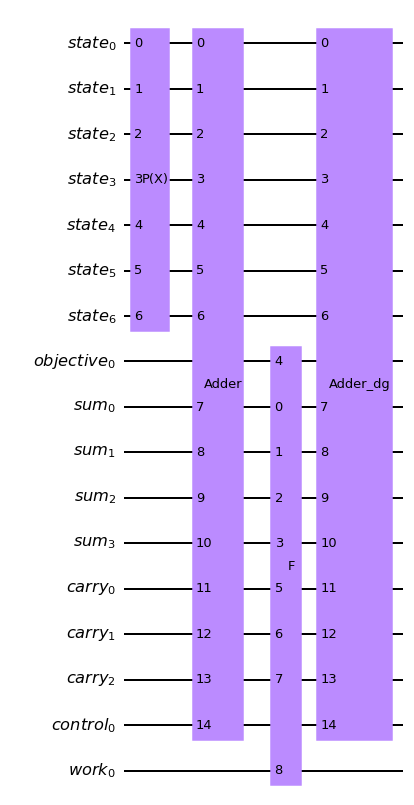

In [39]:
# define the registers for convenience and readability
cvar_qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
cvar_qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
cvar_qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
cvar_qr_obj = QuantumRegister(1, 'objective')
cvar_qr_work = QuantumRegister(cvar_objective.num_ancillas - len(cvar_qr_carry), 'work')

if weighted_adder.num_control_qubits > 0:
    cvar_qr_control = QuantumRegister(weighted_adder.num_control_qubits, 'control')
    cvar_state_preparation = QuantumCircuit(cvar_qr_state, cvar_qr_obj, cvar_qr_sum, cvar_qr_carry, cvar_qr_control, cvar_qr_work, name='A')
    cvar_state_preparation.append(uncertainty_model, cvar_qr_state)
    cvar_state_preparation.append(weighted_adder, cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:] + cvar_qr_control[:])
    cvar_state_preparation.append(cvar_objective, cvar_qr_sum[:] + cvar_qr_obj[:] + cvar_qr_carry[:] + cvar_qr_work[:])
    cvar_state_preparation.append(weighted_adder.inverse(), cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:] + cvar_qr_control[:])
else:
    cvar_state_preparation = QuantumCircuit(cvar_qr_state, cvar_qr_obj, cvar_qr_sum, cvar_qr_carry, cvar_qr_work, name='A')
    cvar_state_preparation.append(uncertainty_model, cvar_qr_state)
    cvar_state_preparation.append(weighted_adder, cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:])
    cvar_state_preparation.append(cvar_objective, cvar_qr_sum[:] + cvar_qr_obj[:] + cvar_qr_carry[:] + cvar_qr_work[:])
    cvar_state_preparation.append(weighted_adder.inverse(), cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:])

cvar_state_preparation.draw('mpl')


In [40]:
job = execute(cvar_state_preparation, backend=Aer.get_backend('statevector_simulator'))
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(cvar_qr_state) + 1)).format(i)[-(len(cvar_qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = (1.0 - estimated_probability)
v = value / d if d != 0 else 0
normalized_cvar = v + var
print('Estimated CVaR: $ {0:9,.0f}'.format(normalized_cvar * lgd_factor))
print('Exact CVaR: $ {0:9,.0f}'.format(exact_cvar * lgd_factor))

Estimated CVaR: $   578,214
Exact CVaR: $   492,839


In [41]:
# set target precision and confidence level
epsilon_iae = 0.01
alpha_iae = 0.05

# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(state_preparation=cvar_state_preparation,
                                       epsilon=epsilon_iae, alpha=alpha_iae,
                                       objective_qubits=[len(cvar_qr_state)],
                                       post_processing=cvar_objective.post_processing)
result_cvar = ae_cvar.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [42]:
# print results
d = (1.0 - estimated_probability)
v = result_cvar['estimation'] / d if d != 0 else 0
print('Estimated CVaR: $ {0:9,.0f}'.format((v + var) * lgd_factor))
print('Exact CVaR: $ {0:9,.0f}'.format(exact_cvar * lgd_factor))
print('Error: ', 1-(exact_cvar) / (v+var))

Estimated CVaR: $   592,831
Exact CVaR: $   492,839
Error:  0.16866909373098526


### Lots of errors in your CVaR calculation right?

You are a smart cookie. And the answer is yes. Neither QAE or IQAE provide an accurate estimation of the Expected Shortfall due to the discretization of the probability distribution. In the case of QAE the number of evaluation qubits affects as well, while on the IQAE the hyperparameters for fine tunning the angle. 

In our experiments we've found the optimal amount of qubits for Z in 5, but that grows the qubit count linearly and becomes impossible to simulate. So 3 is "good enough"

![](imgs/cvar_errors_by_z.png)



## The Bloody Noise

As you know, our current qubits are noisy little buggers. Depending on the device, the circuit depth and the gates you use, you have high chances of hitting decoherence, bit flips, phase flips and all kinds of weird errors that will destroy your calculations.

For our circuit, we could not use a real device since IBM won't let us use their 50 qubit thing, and the 16 Qubit Melbourne is too small. However we can use its noise model and add it to our simulation (just because!). This is the result.

![](imgs/qae_simplified_noise.png)



## Some Conclusions

* QAE, or any other QPE / QFT based algorithms are too long and too qubit intensive to be able to solve any problem at all (in our example 3 assets maximum)
* The current circuit is not efficient at all. Our weighted adder skips many qubits. It is likely there are better ways to build the comparator. And the number of qubits grows linearly with K and with the total loss. (the sum). So in order to play with "real" amounts we have to simplify.
* The paper used $\lambda = [1,2]$ where we have tried to use real numbers on the morgages and apply reductions. It can't even be considered a toy model.

* We have been able to solve up to 16 assets with 20% divergence on CVaR from the classical calculated one.
* Our classical MC is unfair for the classical computer, since we are "handicapping" it on the discretization (i.e. assuming the classical would be able to discretize Z only with the amount of qubits we use on the QC). However as we have seen larger numbers of qubits for Z do not necessary reflect higher precission.
* Noise: Once you add noise in the circuit, or use a real device, results go all over the place. Some noise reduction algorithms could be used but they will not get you too far. We will have to wait until we have better less noisy qubits before seeing proper results

* This approach can be used to model any probability distribution function representing a financial model. I.e. option pricing, stock dividends, portfolio risk, or even try to predict financial crashes. Provided that you trust your uncertainty model. Looks cool uh? Well, wait until we get some more qubits!

* Finally. The classical method is fundamentally flawed since it relies on handpicked sensitivity data. Real quants don't use Expected Shortfall as an absolute term but as an evolutionary parameter to control its portfolio. Even with that it is a highly stochastic process that relies on many random parameters. So we are realizing an order of magnitude improvement over a system that does not work in any case. This paper was a PR stunt between Caixa and IBM to sell them classical cloud provisioning. Money talks my friends!

## Bonus Track
We have mixed a KClutering method to analize a Fannie Mae US mortgage dataset, select its values and cluterize them by risk. We have used some of its parameters to add sensitivities thanks to the insight from a few quants I now owe a bottle of wine, and with that we've been able to run groups of subadditivity-friendly clusters to the quantum computer. With that we have been able to merge a classical ML algo + quantum to calculate the expected shortfall of 25000 assets with over $6B in assets and a very similar accuracy to montecarlo methods. That is cool!


# Other Papers
* https://www.researchgate.net/publication/341342061_Comparison_of_Amplitude_Estimation_Algorithms_by_Implementation - Comparison of Amplitude Estimation Algorithms by Implementation. Kwangmin Yu, Hyunkyung Lim, Pooja Rao, Dasol Jin
* Option Pricing using Quantum Computers
Nikitas Stamatopoulos1, Daniel J. Egger2, Yue Sun1, Christa Zoufal2,3, Raban Iten2,3, Ning Shen1, and Stefan Woerner2
* https://arxiv.org/abs/2103.05475 - A Quantum Algorithm for the Sensitivity Analysis of Business Risks
M. C. Braun, T. Decker, N. Hegemann, S. F. Kerstan, C. Schäfer

# That's all folks!
![](imgs/foreclosure.jpg)